In [1]:
import numpy as np
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import random
from scipy.stats import norm

import os
import pathlib

torch.autograd.set_detect_anomaly(True)
# start_time=datetime.now().strftime('%B %d - %H:%M:%S')

# Simplified Problem Overview
>## 2-(Counpled-)FBSDE System:
### Smooth Continuously Defferentiable Terminal Condition
Suppose we have the following problem on $(\Omega,\mathcal{F},\mathbb{F, P})$ where $\mathbb{F}$ is the filtration generated by a Brownian
motion $B = (B_t)_{t\ge 0}$:

$$
F(a,x):=\mathbb{E}\left[\frac{1}{2}\int_0^T{{a_s}^2ds+g(X_T^{0,x})}\right]
$$

$$
J(x):=\inf_{a\in \mathcal{A}}F(a,x)=\inf_{a\in \mathcal{A}}{\mathbb{E}\left[\frac{1}{2}\int_0^T{{a_s}^2ds+g(X_T^{0,x})}\right]}
$$

This optimization is over $\mathcal{A}:=\{a=(a_t)_{t\in [0,T]}\}$ such that $a$ is adapted to $\mathbb{F}$. For simplicity we let

$$X_t=x+\int_0^t{a_sds+\sigma B_t}$$

and assume that $g$ is continuously differentiable (e.g. $g(u)={u}^2$).

Our control is the “drift” of $X$, i.e. the control process $a$. For a fixed control $a$, we can consider another adapted process $\eta = (\eta_t)_{t≥0}$ and perturb $a$ by $\epsilon> 0$ in the direction of $\eta$:
 
$$
a+ \epsilon \eta 
$$ .

Naively and intuitively, we “differentiate” the objective function $F(a,x)$ in an arbitrary perturbation direction $\eta$ to find the optimal control:

$$
\delta_{\eta}F(a,x):=\underset{\epsilon\downarrow0}{\lim}{\frac{F(a+\epsilon\eta,x)-F(a,x)}{\epsilon}}
$$

Note that:

$$\delta_\eta X_t=\int_0^t{\eta_s ds}$$

and under appropriate and sufficient integrability assumptions, we can naively pass limits under the integrals and/or expectations:

$$
\begin{align}
\delta_{\eta}F(a,x) &= \mathbb{E}\left[\int_0^T{{a_s}\eta_s ds+g'(X_T^{0,x})\int_0^T{\eta_s ds}}\right] \\ 
&= \mathbb{E}\left[\int_0^T{\left[a_s+g'(X_T^{0,x})\right]}\eta_s ds\right]\\
\end{align}
$$

By Fubini’s Theorem and Iterated Conditioning:

$$
\begin{align}
\mathbb{E}\left[ \int_0^T{\left(a_s+g'(X_T^{0,x})\right)} \eta_s ds \right]
&= \int_0^T{\mathbb{E}\left[ \left(a_s+g'(X_T^{0,x})\right) \eta_s  \right]ds} \\ 
&= \int_0^T{\mathbb{E}\left[\mathbb{E}\left[ \left(a_s+g'(X_T^{0,x})\right) \eta_s |\mathcal{F}_s\right]\right]ds}\\
&= \mathbb{E}\left[ \int_0^T{\mathbb{E}\left[ \left(a_s+g'(X_T^{0,x})\right) \eta_s |\mathcal{F}_s\right]ds}\right]
\end{align}
$$

Taking out what is known:

$$
    \mathbb{E}\left[ \int_0^T{\mathbb{E}\left[ \left(a_s+g'(X_T^{0,x})\right) \eta_s |\mathcal{F}_s\right]ds}\right] = \mathbb{E}\left[ \int_0^T{\left[ a_s+\mathbb{E}\left[g'(X_T^{0,x})|\mathcal{F}_s\right] \right] \eta_sds}\right]
$$

Taken together we now have:

$$
    \delta_{\eta}F(a,x) =\mathbb{E}\left[ \int_0^T{\left[ a_s+\mathbb{E}\left[g'(X_T^{0,x})|\mathcal{F}_s\right] \right] \eta_sds}\right]
$$

To minimize $F$ over adapted $a$, we solve for $a$ satisfying the following first order condition for __all__ adapted $\eta$:

$$
\delta_{\eta}F(a,x) =\mathbb{E}\left[ \int_0^T{\left[ a_s+\mathbb{E}\left[g'(X_T^{0,x})|\mathcal{F}_s\right] \right] \eta_sds}\right]=0
$$

It is possible to show that this holds __if and only if__:

$$
a_s=-\mathbb{E}\left[g'(X_T^{0,x})|\mathcal{F}_s\right]
$$

almost surely for almost every $s \in [0,T]$. If we apply the Martingale Representation Theorem we get that there exists an $a_0 = −\mathbb{E}\left[g'(X_T^{0,x})\right]$ and adapted $Z = (Z_t)_{t\ge 0}$ such that

$$a_t=a_0+\int_0^T{Z_s dB_s}$$

and $a_T = −g'(X_T^{0,x})$ (i.e. the terminal condition). Taking $g(u)={u}^2, g'(u)=2u$, and putting all above together with the dynamics of $X$ (which depend on $a$) we arrive at the following __Forward-Backward Stochastic Differential Equation (FBSDE)__:

$$
    \begin{cases}
    d X_t = a_tdt+\sigma dB_t, &X_0=x \\
    d a_t = Z_t dB_t, &a_T= −g'(X_T^{0,x})=-2X_T^{0,x}
    \end{cases}
$$

This characterizes the first order condition. We can search for a solution of the optimization problem by searching over measurable initial conditions a0 and adapted volatilities $Z = (Z_t)_{t\ge 0}$, so that we match the terminal condition of the FBSDE over all initial values $X_0=x$ and paths of $B = (B_t)_{t\ge 0}$. 

To solve this _numerically_ , we can __discretize__ the FBSDE and __parameterize__ $a_0$ and $Z_t$ on the discrete grid $0 = t_0 < t_1 < ··· < t_{NT} = T=1$ by Neural Networks, taking $X_0=x$ and $X_t$ as inputs, respectively. 

$$
    \begin{cases} 
    X_{t_i} = X_{t_{i-1}} + a_{t_{i-1}}(t_i-t_{i-1})+\sigma dB_{t_{i-1}}, &X_0=x \\ 
    a_{t_i} = a_{t_{i-1}} + Z_{t_{i-1}}dB_{t_{i-1}}, &a_T=-2X_T^{0,x}
    \end{cases}
$$

Using numerical approximations we can try to minimize the loss:

$$\frac{1}{N}\sum_{i=1}^N{\left( a_T(\omega_i)+2X_T^{0,x} \right)^2}$$

over N samples $\omega_i\in \Omega$ that define trajectories of the Brownian Motions $B_i$ (i = 1,...,N). 

We decompose this simplified problem into the following 5 steps:

>- Simulate independent Brownian Motion samples for training set
>
>- Build Neural Network model
>
>- Build training loop to train the model with appropriate optimizer, learning rate (and scheduler), and loss function
>
>- Make inference with trained model and get the processes paths
>
>- Visualize the results


## `Step 1` Simulate Independents BM Samples
Generate 500 independent Brownian Motion processes with 80 equal increments within a unit time range [0,1].

Since BMs have independent normally distributed increments: $dB_t \sim \mathcal{N}(0,dt)$, they can be simulated in the following way:

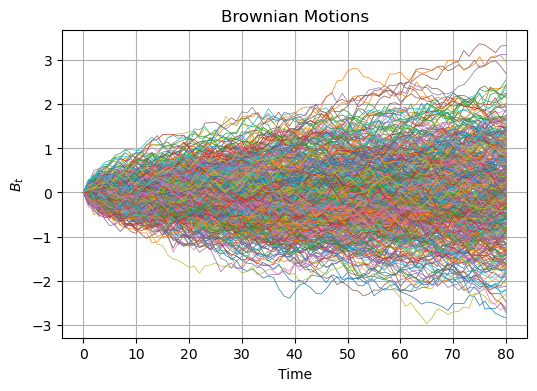

In [2]:
## ------------------------------------- Parameters ------------------------------------- ##
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
NumTrain = 500
NT=80
## ------------------------------------- Simulation ------------------------------------- ##
def SampleBMIncr(T, Npaths, Nsteps,seed=42):
    torch.manual_seed(seed=seed)  ## For replicability, set defualt random seed to 42
    dt = T / Nsteps ## Time increment / Step size
    dB = np.sqrt(dt) * torch.randn(size=(Npaths, Nsteps)) 
    return dB.to(device)
dB= SampleBMIncr(T=1,Npaths=NumTrain, Nsteps=NT)
B=np.hstack([np.zeros((NumTrain,1)),dB.detach().numpy().cumsum(axis=1)])
## ------------------------------------- Visualization ------------------------------------- ##
plt.figure(figsize=(6,4))
plt.subplot()
plt.plot(B.T,linewidth=0.5)
plt.title("Brownian Motions")
plt.xlabel("Time")
plt.ylabel("$B_t$")
plt.grid()

## `Step 2` Build Neural Network Model
Build a NN model with 2 hidden layers with 10 nodes (4 layers in total).

We initilize the wights of each linear layer using an __Xavier Uniform Distribution__, as is described in _Understanding The Difficulty of Training Deep Feedforward Neural Networks_ - Glorot, X. & Bengio, Y. (2010). (Also known as __Glorot initialization__). And as for non-linear activations, we choose __Relu__ functions.

The NN model class `Network` is built as follows:

In [3]:
## ------------------------------------- Build Model ------------------------------------- ##
class Network(nn.Module):
    def __init__(self, input_dims=[1], fc1_dims=10, fc2_dims=10, n_outputs=1,seed=42):
        '''
        input_dims, fc1_dims, fc2_dims, n_outputs: number of nodes (functions) in each layer.
        For replicability, set defualt random seed to 42
        '''
        torch.manual_seed(seed=seed) 
        super(Network, self).__init__()
        # Input parameters
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_out = n_outputs

        # Construct network
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        nn.init.xavier_uniform_(self.fc1.weight)
        self.relu1=nn.ReLU()
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        nn.init.xavier_uniform_(self.fc2.weight)
        self.relu2=nn.ReLU()
        self.fc3 = nn.Linear(self.fc2_dims, self.n_out)
        nn.init.xavier_uniform_(self.fc3.weight)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    def forward(self,input):
        model=nn.Sequential(self.fc1,
                            self.relu1,
                            self.fc2,
                            self.relu2,
                            self.fc3)
        x=model(input)
        return x.to(self.device)


## `Step 3` Build Training Loop
We will modelize the discretized $a_0$ and $Z_t$ processes, using $X_t (t \ge 0)$ as inputs. To train these NN models, we will:

- Select an appropriate optimizer (`torch.optim`)

- Select an appropriate learning rate (`learning_rate`) and an appropriate scheduler for it (`torch.optim.lr_scheduler`)

- Define target and loss function (MSE)

- Generate normally distributed initial values $X_0 \sim \xi = \mathcal{N} (v, \eta)$

- Build up training loop (with specified batch numbers and optimization steps).

In [4]:
## ------------------------------------- Initial Values of X ------------------------------------- ##
def Sample_Init(N,mean,std,seed=42):
    '''
    Generate N samples of normally distributed x0 (tensor)
    For replicability, set defualt random seed to 42
    '''  
    torch.manual_seed(seed=seed)
    return torch.normal(mean=mean,std=std,size=(N,1)).to(device)
## ------------------------------------- Target Function ------------------------------------- ##
def target(x):  ## a_T = -g'(X_T) = -2X_T
    return (-2*x).to(device)
## ------------------------------------- Forward Loop And Loss Function ------------------------------------- ##
def get_foward_loss(dB, init_x, NT , target, a0_model, z_models):
    x =  init_x
    a = a0_model(x)
    for j in range(1, NT+1):
        z = z_models[j-1](x)
        x = x + a*dt + dB[:,j].view(-1,1)
        a = a  + z * dB[:,j].view(-1,1)
    return torch.mean((a-target(x))**2).to(device)   ## MSE loss function


## ------------------------------------- Parameters for Optimization ------------------------------------- ##
#Set the random seed to 42
torch.manual_seed(42)  
dt=1/NT
mean=0.6
std=0.1
dB = SampleBMIncr(1, Npaths=NumTrain, Nsteps=NT+1)
init_x =  Sample_Init(N=NumTrain,mean=mean,std=std)


#Parameterized NN Modles
a0_model_main = Network()
z_models_main = [Network() for i in range(NT)]

#Define optimization parameters
params = list(a0_model_main.parameters())
for i in range(NT):
    params += list(z_models_main[i].parameters())

#Set up optimizer, learning rate and scheduler
learning_rate = 0.001
optimizer = optim.Adamax(params, lr=learning_rate)  ## we also tried other optimizers like Adam, SGD... But Adamax works best
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)  ## we also tried other shedulers and fine tuned the parameters

#To record training forward losses
forward_losses = []

#How many batches?
MaxBatch= 500

#How many optimization steps per batch
OptimSteps= 25

#Train on a single batch?
single_batch = True

## ------------------------------------- Training And Optimization Loop ------------------------------------- ##
for k in range(0,MaxBatch):
    print("Batch Number: ", k+1)
    sloss=0 ## sum_loss
    #optimize main network wrt the foward loss
    for l in range(0,OptimSteps):
        optimizer.zero_grad()
        loss = get_foward_loss(dB, init_x, NT=NT,target=target, a0_model=a0_model_main, z_models=z_models_main)
        loss.backward()
        optimizer.step()
        scheduler.step()
        sloss += loss.detach().numpy()   
    avgloss = sloss/OptimSteps
    print("Average Error Est: ", avgloss)
    forward_losses.append(avgloss)

    #Generate a new batch if using multiple batches
    if(not single_batch):
        torch.manual_seed(k)  #For replicability, set the random seed to k (current batch number)
        dB = SampleBMIncr(1, Npaths=NumTrain, Nsteps=NT+1,seed=k)
        init_x =  Sample_Init(N=NumTrain, mean=mean, std=std,seed=k)

Batch Number:  1
Average Error Est:  0.8804448914527893
Batch Number:  2
Average Error Est:  0.4739360690116882
Batch Number:  3
Average Error Est:  0.31100193738937376
Batch Number:  4
Average Error Est:  0.22216955780982972
Batch Number:  5
Average Error Est:  0.167082536816597
Batch Number:  6
Average Error Est:  0.12913848370313644
Batch Number:  7
Average Error Est:  0.10047672241926194
Batch Number:  8
Average Error Est:  0.07899677842855453
Batch Number:  9
Average Error Est:  0.06349790811538697
Batch Number:  10
Average Error Est:  0.0519824706017971
Batch Number:  11
Average Error Est:  0.043142801970243456
Batch Number:  12
Average Error Est:  0.03624438256025314
Batch Number:  13
Average Error Est:  0.030899892523884774
Batch Number:  14
Average Error Est:  0.026677099615335466
Batch Number:  15
Average Error Est:  0.023183452934026717
Batch Number:  16
Average Error Est:  0.02029570609331131
Batch Number:  17
Average Error Est:  0.017978661730885505
Batch Number:  18
Avera

## `Step 4` Make Inference And Get Paths
We use the trained model to make inference and get the process paths with a stepwise for-loop. 

In [15]:
def get_target_path(dB, init_x, NT , a0_model, z_models):
    x_path=torch.ones(NumTrain,NT+1).to(device)
    a_path = torch.ones(NumTrain,NT+1).to(device)
  
    for j in range(0, NT+1):
        if j==0:
            x =  init_x
            a = a0_model(x)
        else: 
            z = z_models[j-1](x)
            x = x + a*dt + dB[:,j].view(-1,1)
            a = a  + z * dB[:,j].view(-1,1)
        x_path[:,j]=x.squeeze()
        a_path[:,j]=a.squeeze()
    return x_path, a_path

## `Step 5` Visualization
We then visualize the training results through:
- __Loss Plot__: Forward loss is descending with training steps increasing
- __Path Plot__: The paths of $(a_t)_{t\ge 0}$ closely approximate -2 times of $(X_t)_{t\ge 0}$
- __QQ-Plot__: The terminal values $(a_t)_{t\ge 0}$ closely approximate 2 times of $(X_t)_{t\ge 0}$,
indicated by the dots closely clinging to the straight diagnal line.

In [28]:
class plot_results():
    def __init__(self,loss=forward_losses,Npaths=100,NumTrain=NumTrain,NT=NT):
        self.loss=loss
        self.x_path,self.y_path=get_target_path(dB, init_x, a0_model=a0_model_main, z_models=z_models_main, NT=NT)
        self.number_of_paths=np.minimum(Npaths,NumTrain)
    
    def FwdLoss(self,log=True):
        plt.figure(figsize=(10,4))
        plt.title("Forward_Loss vs Batch",fontsize=18)
        plt.plot(self.loss)

        if log==True:
            plt.yscale('log')

    def Path(self,seed=0):
        random.seed(seed)
        idx_list = np.random.choice(NumTrain, self.number_of_paths, replace = False)
        x_plot = self.x_path.detach().numpy()[idx_list]
        y_plot = self.y_path.detach().numpy()[idx_list]
        t = np.array([i for i in range(NT+1)]) * 1/(NT)
        plt.figure(figsize=(10,3))
        plt.subplot(121)
        for i in range(self.number_of_paths):
                plt.plot(t,x_plot[i], color="blue", alpha=0.5)
        plt.title("X")

        plt.subplot(122)
        for i in range(self.number_of_paths):
                plt.plot(t,y_plot[i], color="red", alpha=0.5)
        plt.title("Y Values")
    
    def QQ_plot(self):
        plt.figure(figsize=(5,5))
        plt.title("QQ-Plot")
        targ=target(self.x_path[:,-1]).detach().numpy()
        plt.scatter(targ,self.y_path[:,-1].detach().numpy(),s=3)
        plt.xlabel("target -2$X_T$")
        plt.ylabel('trained $a_T$')
        # plt.plot(np.linspace(-1,1,5),np.linspace(-1,1,5),linestyle='--',linewidth=1,color='r')

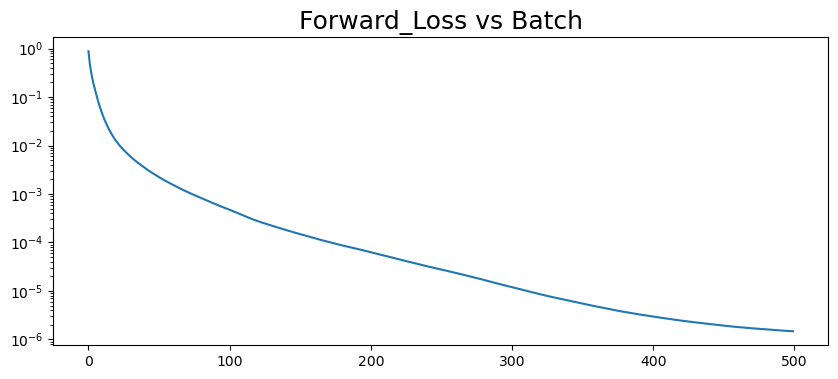

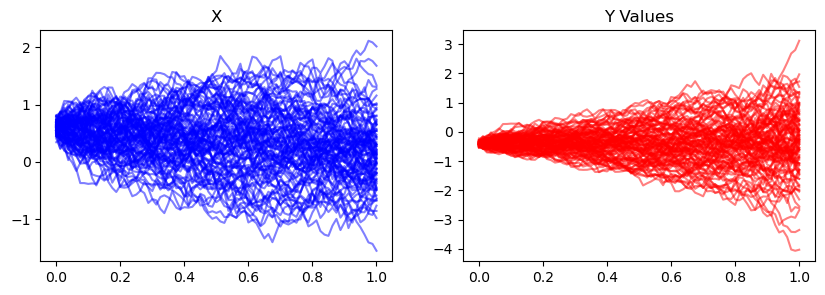

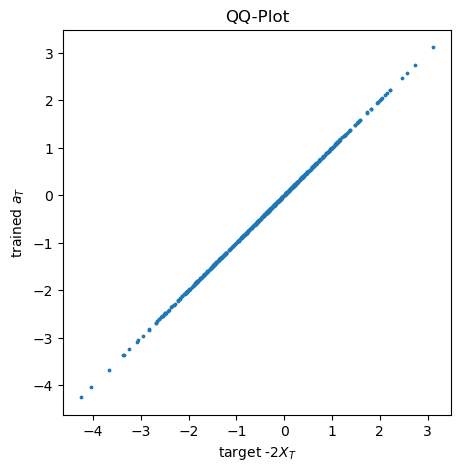

In [29]:
#Log-Forward_loss
plot=plot_results(loss=forward_losses,Npaths=100)
plot.FwdLoss()
plot.Path()
plot.QQ_plot()